# Compare the data from different slit positions
The `B` position shows a CO detection at ~ 5 SNR yet data from `A` does not show any detection

In [1]:
#------ manually fix import for now
import sys, os
sys.path.append('../src/')
#------
import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
from redcross.read import read_giano
from redcross.datacube import Datacube
from redcross.cross_correlation import CCF, KpV, Template
from redcross.planet import Planet
from redcross.pipeline import Pipeline


%load_ext autoreload
%autoreload 2

In [2]:
night = '1'
position = 'B'
data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, position)

dc = []
order = 48
positions = ['A','B']
for p in positions:
    data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, p)
    dc.append(Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(p)).order(order))
    
    dc[-1].flux_err[dc[-1].flux_err==0.] = np.nan # avoid issues when computing SNR
    
# planet = Planet('wasp189', **dc.get_header().header)

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posA/datacube_input_posA.npy
Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posB/datacube_input_posB.npy


### Flux throughput 

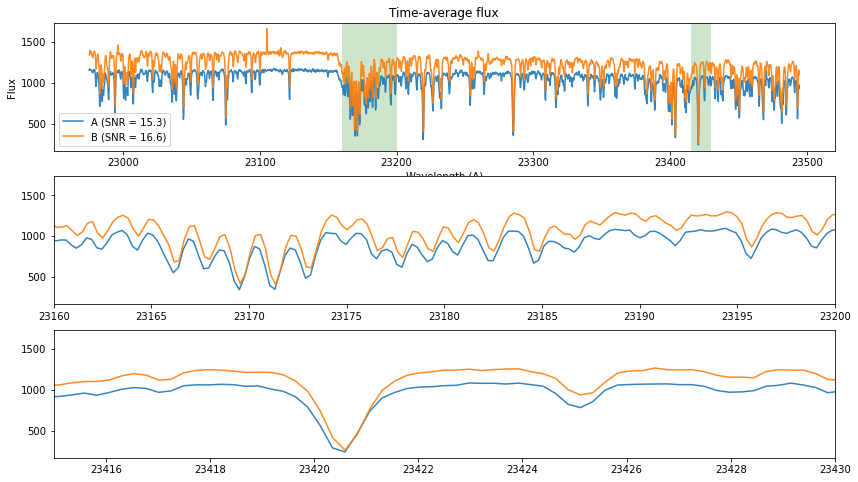

In [3]:
%matplotlib inline
fig, ax = plt.subplots(3, figsize=(14,8))

xranges = [(23160, 23200), (23415, 23430)]

for i in range(2):
    master = Datacube(wlt=np.median(dc[i].wlt, axis=0), 
                      flux=np.median(dc[i].flux, axis=0), flux_err=np.median(dc[i].flux_err, axis=0))
    snr = np.nanmean(master.flux / master.flux_err)
    
    [ax[k].plot(master.wlt, master.flux, alpha=0.9,
                label='{:} (SNR = {:.1f})'.format(positions[i], snr)) for k in range(3)]
for i, xrange in enumerate(xranges):
    ax[i+1].set_xlim(xrange)
    ax[0].axvspan(xrange[0], xrange[1], alpha=0.2, fc='green')
    
ax[0].legend()
ax[0].set(xlabel='Wavelength (A)', ylabel='Flux', title='Time-average flux')
plt.show()

### Wavelength solution

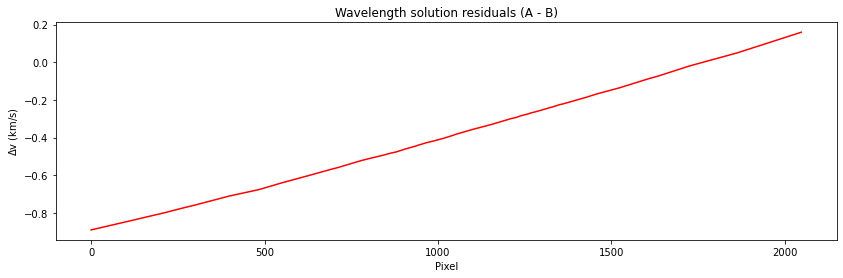

In [4]:
fig, ax = plt.subplots(1, figsize=(14,4))
c = 2.99e5 # km/s
res = c * (np.median(dc[0].wlt, axis=0) - np.median(dc[1].wlt, axis=0)) / np.median(dc[0].wlt)
ax.plot(res, '-r')

ax.set(xlabel='Pixel', ylabel='$\Delta$v (km/s)', title='Wavelength solution residuals (A - B)')
plt.show()

### Frame alignment

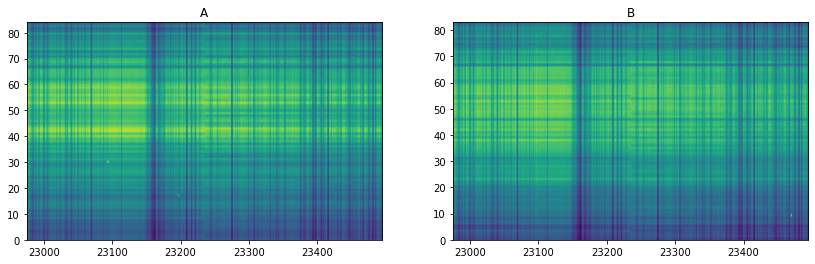

In [5]:
fig, ax = plt.subplots(1,2,figsize=(14,4))
for i in range(2):
    dc[i].imshow(ax=ax[i])
    ax[i].set_title(positions[i])
plt.show()

Aligning with 3 reference lines
Aligning with 5 reference lines


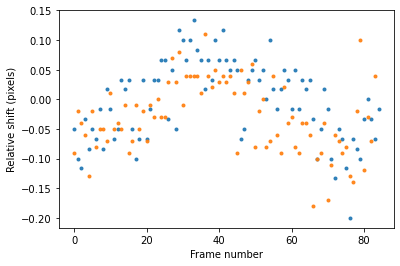

In [6]:
for i in range(2):
    dc[i].remove_continuum()
    dc[i].align(ax=plt.gca())

### Define reduction steps in the `Pipeline` instance

In [43]:
pipe = Pipeline(steps=[])     
pipe.add('remove_continuum', {'mode':'polyfit'})
pipe.add('sigma_clip')
# pipe.add('inject_signal', {'factor':60., 'planet':planet, 'template':template})
pipe.add('mask_cols', {'sigma':1.2, 'mode':'flux', 'debug':True})
pipe.add('airmass_detrend')
# pipe.add('mask_cols', {'sigma':1.2, 'mode':'flux', 'debug':True})
pipe.add('mask_cols', {'sigma':2.5, 'mode':'flux_err', 'cycles':2, 'debug':True})
pipe.add('sysrem', {'n':5, 'debug':True})
pipe.add('high_pass_gaussian', {'window':15})
pipe.add('sigma_clip', {'sigma':3.})
# pipe.add('mask_cols', {'sigma':2., 'cycles':2, 'mode':'flux_err'})

### Run the pipeline for each half-order and merge them in `dcm` = datacube_merged

In [46]:
def wrapper(dc, pipe, ax=None):

    dcs = dc.split_orders(debug=False)

    wave, flux, flux_err = ([] for _ in range (3)) 
    axs = [ax, None, None, None]
    for order in range(4):
        dco = dcs.order(order) # split order in two sections (flux jump) and select a half-order to work with
        dco = pipe.reduce(dco, ax=axs[order])

    #     dcs.wlt[order,:] = dco.wlt
    #     dcs.flux[order,:,:] = dco.flux
    #     dcs.flux_err[order,:,:] = dco.flux_err
        wave.append(dco.wlt)
        flux.append(dco.flux)
        flux_err.append(dco.flux_err)

    dcm = Datacube(flux=np.hstack(flux), wlt=np.hstack(wave), flux_err=np.hstack(flux_err))
    # dcm = Datacube(wlt=np.hstack(dcs.wlt), flux=np.hstack(dcs.flux), flux_err=np.hstack(dcs.flux_err))
    nans = np.isnan(dcm.wlt)
    print('{:.2f} % of pixels have been masked'.format(100*dcm.nan_frac))
    return dcm

# Get eclipse mask
# ecl = planet.mask_eclipse(return_mask=True)
species = 'CO_main_iso'
species_name = species.split('_')[0]
template_path = 'data/template_giano_{:}_2500K.npy'.format(species)
twave, tflux = np.load(template_path)

# flux must be continuum subtracted (normalised)
template = Template(wlt=twave, flux=tflux).high_pass_gaussian(window=15)


# Define parameters for cross-correlation and Kp-Vsys map
hpw = 15
# dRV = 2.7
dRV = 1.5
RVt = np.arange(-350,351, dRV)
dkp, kp_amp = dRV, 70 # km/s
vrest_amp, dvrest = 100, dRV # km /s
v_range = [-4.,7.0] # fix color scale

Loading Datacube from... /home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night1/posA/datacube_input_posA.npy
Reducing order...
1. remove_continuum
2. sigma_clip
3. mask_cols 
--> 8.01 % of pixels masked
4. airmass_detrend
5. mask_cols 
--> 2.54 % of pixels masked
--> 3.32 % of pixels masked
6. sysrem    
Convergence at iteration  11 --- StDev = 0.0153


/home/dario/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Convergence at iteration  70 --- StDev = 0.0151
Convergence at iteration  33 --- StDev = 0.0149
Convergence at iteration   4 --- StDev = 0.0147
Convergence at iteration  78 --- StDev = 0.0145
7. high_pass_gaussian
8. sigma_clip
9. mask_cols 
Reducing order...
1. remove_continuum
2. sigma_clip
3. mask_cols 
--Exit at iteration 1--
--> 11.52 % of pixels masked
4. airmass_detrend
5. mask_cols 
--> 2.73 % of pixels masked
--> 2.54 % of pixels masked
6. sysrem    
Convergence at iteration  24 --- StDev = 0.0195
Convergence at iteration  62 --- StDev = 0.0193
Convergence at iteration   8 --- StDev = 0.0190
Convergence at iteration  82 --- StDev = 0.0187
Convergence at iteration  64 --- StDev = 0.0185
7. high_pass_gaussian
8. sigma_clip
9. mask_cols 
Reducing order...
1. remove_continuum
2. sigma_clip
3. mask_cols 
--Exit at iteration 1--
--> 13.18 % of pixels masked
4. airmass_detrend
5. mask_cols 
--> 1.95 % of pixels masked
--> 2.05 % of pixels masked
6. sysrem    
Convergence at iteration

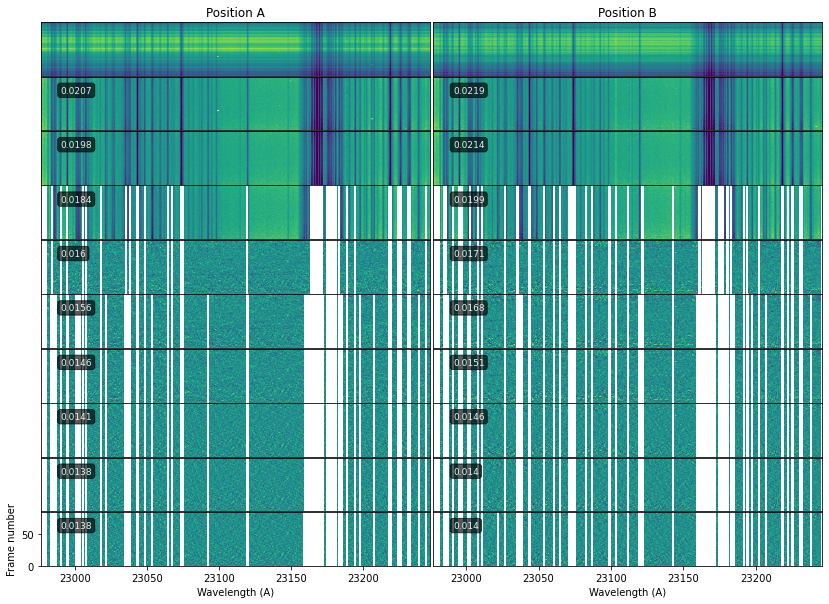

In [97]:
orders = [48,49]
kpv_list, ccf_list = ([] for _ in range(2))

nrows = len(pipe.steps) + 1

fig, ax = plt.subplots(nrows, 2, figsize=(14, nrows))
plt.subplots_adjust(hspace=0.01, wspace=0.01)
[ax[i,j].set(xticks=[], yticks=[]) for i in range(nrows-1) for j in range(2)]
ax[nrows-1, 1].set_yticks([])
ax[nrows-1, 0].set_ylabel('Frame number')

[ax[nrows-1, j].set_xlabel('Wavelength (A)') for j in range(2)]

for k,p in enumerate(positions):
    
    data_dir = '/home/dario/AstronomyLeiden/MRP/wasp189/data/giano/night{:}/pos{:}/'.format(night, p)
    dc = Datacube().load(data_dir+'datacube_input_pos{:}.npy'.format(p)).order(orders)
    
    dc.flux_err[dc.flux_err==0.] = np.nan # avoid issues when computing SNR
    dc.wlt = np.median(dc.wlt, axis=1)
    
    planet = Planet('wasp189', **dc.get_header().header)
    
    
    ax[0,k].set_title('Position {:}'.format(p))
    dcm = wrapper(dc, pipe, ax=ax[:,k])
    
    # Run CCF and KpV
    ccf = CCF(rv=RVt, template=template).run(dcm, weighted=True)
    ccf_list.append(ccf.to_planet_frame(planet))
    kpv = KpV(ccf, planet, [kp_amp, dkp], [vrest_amp, dvrest], bkg=50.)

    kpv.run()#.fancy_figure(peak=[2.7,195], v_range=v_range)
    kpv_list.append(kpv)
    
# fig.savefig('plots/giano_night1_positionsAB_reduction.png', dpi=200, bbox_inches='tight', facecolor='white')

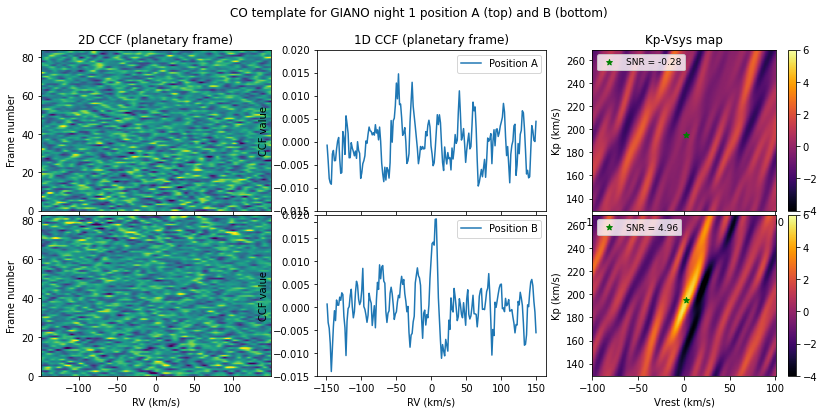

In [98]:
fig, ax = plt.subplots(2,3, figsize=(14,6))
plt.subplots_adjust(hspace=0.025)

for i in range(2):
    
    ccf_list[i].imshow(ax=ax[i,0])
    ax[i,0].set(ylabel='Frame number', xlabel='RV (km/s)', title='2D CCF (planetary frame)')
    
    ax[i,1].plot(ccf_list[i].rv, np.median(ccf_list[i].flux, axis=0), label='Position {:}'.format(positions[i]))
    ax[i,1].set(ylabel='CCF value', xlabel='RV (km/s)', title='1D CCF (planetary frame)', ylim=(-0.015, 0.020))
    ax[i,1].legend()
    
    # Kp-Vsys map
    lims = [kpv.vrestVec[0],kpv.vrestVec[-1],kpv.kpVec[0],kpv.kpVec[-1]]
    vmin, vmax = -4, 6.
    obj = ax[i,2].imshow(kpv_list[i].snr, origin='lower',extent=lims,aspect='auto', 
                         cmap='inferno', vmin=vmin, vmax=vmax)
    ax[i,2].set(ylabel='Kp (km/s)', xlabel='Vrest (km/s)')
    fig.colorbar(obj, ax=ax[i,2], pad=0.05)
    
    peak = [2., 195.]
    indv = np.abs(kpv.vrestVec - peak[0]).argmin()
    indh = np.abs(kpv.kpVec - peak[1]).argmin()
    row = kpv.kpVec[indh]
    col = kpv.vrestVec[indv]
    
    kpv.peak_snr = kpv_list[i].snr[indh,indv]


    
    ax[i,2].set(title='Kp-Vsys map')
    line_args = {'ls':':', 'c':'white','alpha':0.35,'lw':'3.'}
    ax[i,2].scatter(col, row, marker='*', c='green',label='SNR = {:.2f}'.format(kpv.peak_snr))
    ax[i,2].legend(fontsize=9, loc='upper left')

[ax[1,i].set_title('') for i in range(3)]

fig.suptitle('CO template for GIANO night 1 position A (top) and B (bottom)')
plt.show()
# fig.savefig('plots/giano_night1_positionsAB_ccf.png', dpi=200, bbox_inches='tight', facecolor='white')